# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [4]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

## Load processed data

In [6]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print("\n\n\nThe vote dataframe is a " + str(votes.shape) + " table with senators as rows and vote positions as columns.")
display(votes.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
display(bill_descriptions.head(3))

# Separate votes into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.80, votes)

senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The vote dataframe is a (105, 104) table with senators as rows and vote positions as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,hr1-115-289-1,...,sconres3-115-22-1,sconres3-115-23-1,sconres3-115-24-1,sconres3-115-25-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The senators dataframe is a (105, 4) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,name
member_id,,,,
A000360,R,Lamar,Alexander,Lamar Alexander
B000575,R,Roy,Blunt,Roy Blunt
B000944,D,Sherrod,Brown,Sherrod Brown


## Load labels

## Building the similarity graph

In [16]:
features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg, 15),0.5)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)

G = graphs.Graph(adjacency)
G = reduction.graph_sparsify(G, 0.25)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

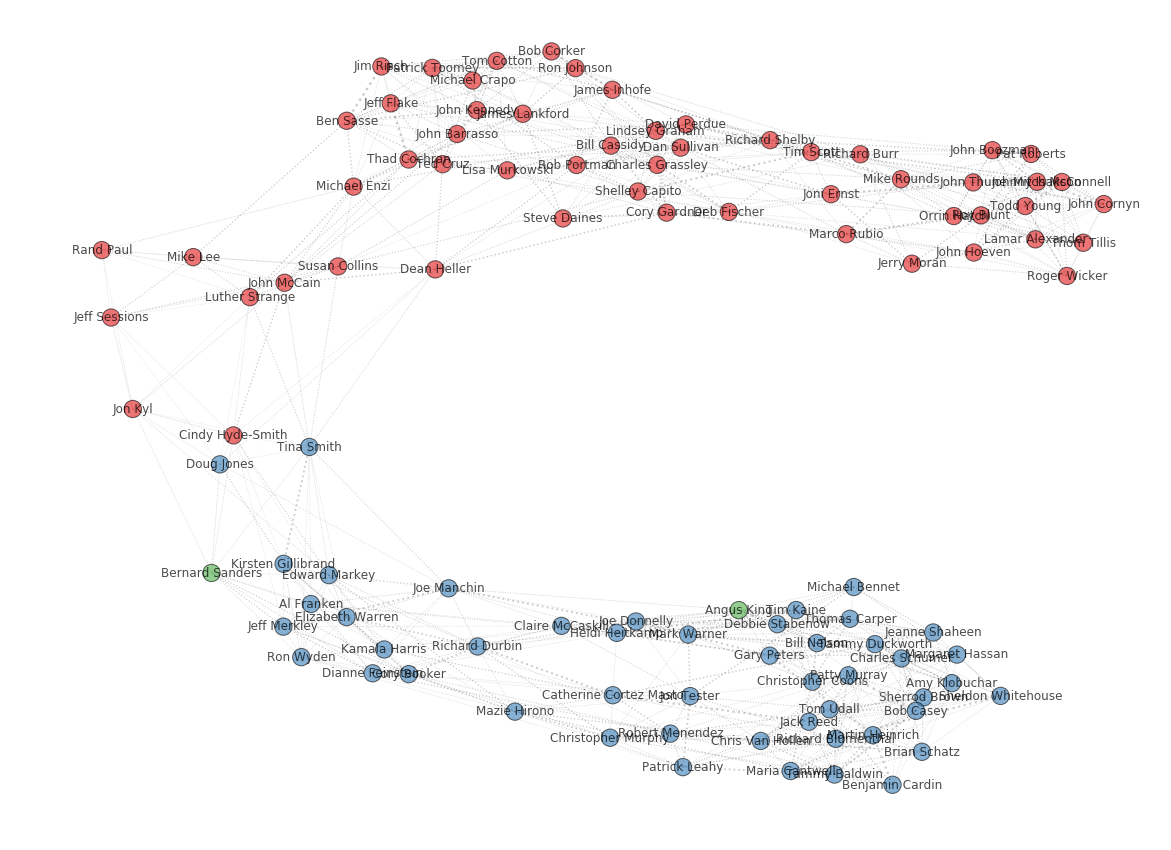

In [17]:
plot_signal(G.W.todense(), numerical_labels, labels=senators['name'], scale=[0,1])

## Clustering the bills

Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

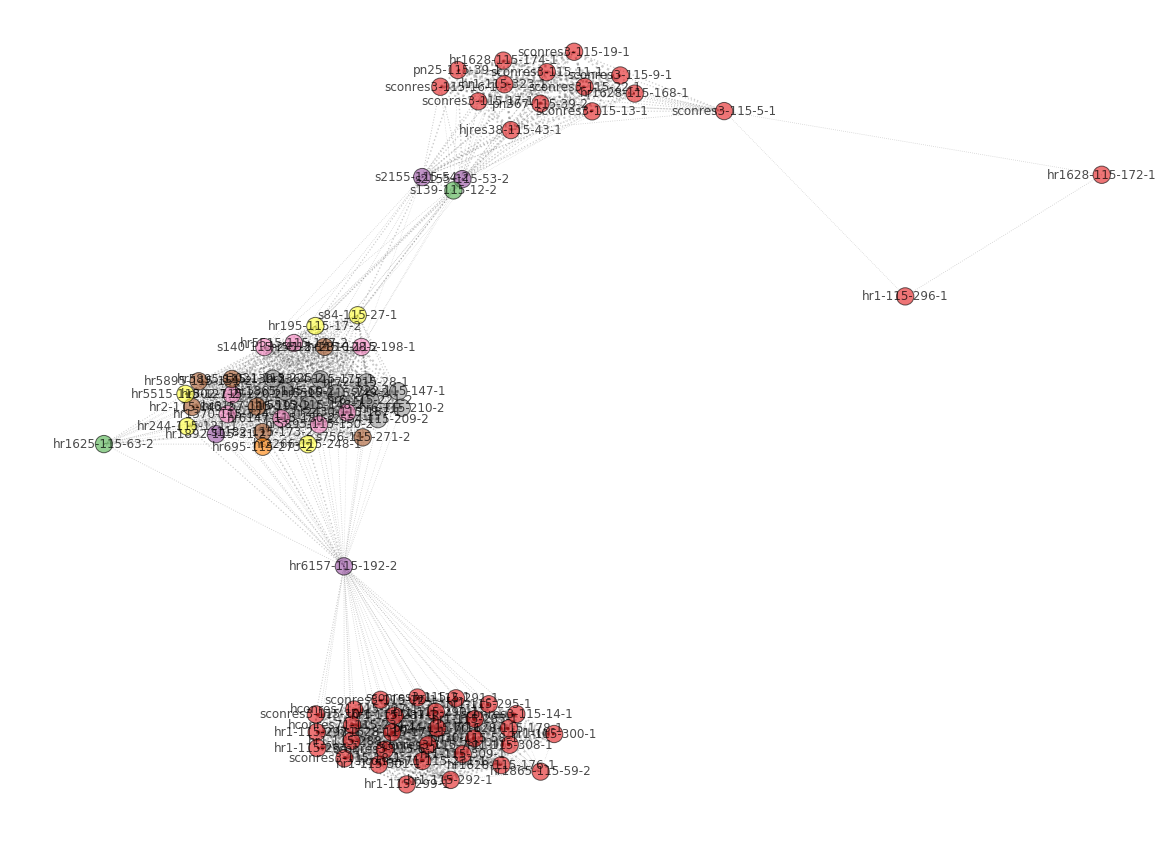

In [90]:
bill_cluster_count = 3

features_bills = [votes_train.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(arg,0.7)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

G_bills = graphs.Graph(adjacency_bills)
#G_bills = reduction.graph_sparsify(G_bills,0.8)

plot_signal(G_bills.W.todense(), votes_train.sum(0) / votes_train.shape[0], labels=votes_train.T.index, scale=[0,1])

node_degrees = adjacency_bills.sum(1)



(array([ 2.,  0.,  2., 14.,  3.,  3., 13., 45.,  0.,  1.]),
 array([ 1.48233509,  5.2315839 ,  8.98083271, 12.73008152, 16.47933033,
        20.22857914, 23.97782795, 27.72707676, 31.47632558, 35.22557439,
        38.9748232 ]),
 <a list of 10 Patch objects>)

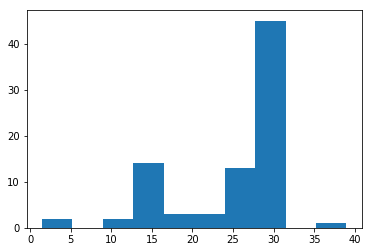

In [92]:
plt.hist(node_degrees)

In [139]:
unique_bills = set()
def print_selected_votes(votes_list,best_bills_idxs):
    selected_votes_unique_ids = votes_train.iloc[:, best_bills].columns.values
    for v in selected_votes_unique_ids:
        print_info(v)
    bills = [x.split('-')[0] for x in selected_votes_unique_ids]
    return set(bills)

    

### Method 1: Get biggest Variance

In [137]:
var = np.zeros(votes_train.shape[1])

for i in range(votes_train.shape[1]):
    a = votes_train.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([59, 20, 61])

In [140]:
unique_bills.update(print_selected_votes(votes_train,best_bills))

============== INFORMATION REGARDING hr1628-115-174-1 ============== 

Roll call: 174
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00174

RELATED BILL INFORMATION

Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2017.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1628

Short description: American Health Care Act of 2017 TITLE I--ENERGY AND COMMERCE Subtitle A--Patient Access to Public Health Programs  (Sec. 101) This bill amends the Patient Protection and Affordable Care Act (PPACA) to eliminate funding after FY2018 for the Prevention and Public Health Fund, which provides for investment in prevention and public health programs to improve health and restrain the rate of growth in health care costs. Funds that are unobligated at the end of FY2018 are rescinded.  (Sec. 102) The...



============== INFORMATION REGARDING sconres3-115

### Method 2: Get smallest number of neighbors

In [115]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([ 1, 40, 23])

In [116]:
selected_votes_unique_ids = votes_train.iloc[:, best_bills].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING hr1628-115-172-1 ============== 

Roll call: 172
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00172

RELATED BILL INFORMATION

Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2017.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1628

Short description: American Health Care Act of 2017 TITLE I--ENERGY AND COMMERCE Subtitle A--Patient Access to Public Health Programs  (Sec. 101) This bill amends the Patient Protection and Affordable Care Act (PPACA) to eliminate funding after FY2018 for the Prevention and Public Health Fund, which provides for investment in prevention and public health programs to improve health and restrain the rate of growth in health care costs. Funds that are unobligated at the end of FY2018 are rescinded.  (Sec. 102) The...



============== INFORMATION REGARDING hr1-115-296-

### Method 3: Get closest points of the centers of the cluster of the Bills

In [117]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()

embedding = G_bills.U[:,1:1+bill_cluster_count]
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    dist = np.linalg.norm(embedding - centers[j],axis=1)
    vote_repr[j] = np.argmin(dist)
            
vote_repr

array([44., 70.,  1.])

In [118]:
selected_votes_unique_ids = votes_train.iloc[:, vote_repr].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING hr5515-115-149-2 ============== 

Roll call: 149
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00149

RELATED BILL INFORMATION

Bill title: To authorize appropriations for fiscal year 2019 for military activities of the Department of Defense and for military construction, to prescribe military personnel strengths for such fiscal year, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr5515

Short description: National Defense Authorization Act for Fiscal Year 2019 This bill authorizes FY2019 appropriations and sets forth policies regarding the military activities of the Department of Defense (DOD), military construction, and the national security programs of the Department of Energy (DOE). It does not provide budget authority, which is provided in subsequent appropriations legislation.  The bill authorizes appropriations to DOD for: (1) Procurement,

### Method 4: Get the bills with biggest intracluster std

In [119]:
var = np.zeros(votes_train.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes.iloc[rep_indexes]
dem_data = votes.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([15, 29, 39])

In [120]:
selected_votes_unique_ids = votes_train.iloc[:, best_bills].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING s2554-115-209-2 ============== 

Roll call: 209
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00209

RELATED BILL INFORMATION

Bill title: A bill to ensure that health insurance issuers and group health plans do not prohibit pharmacy providers from providing certain information to enrollees.

Bill url:  https://www.govtrack.us/congress/bills/115/s2554

Short description: 



============== INFORMATION REGARDING hr1865-115-59-2 ============== 

Roll call: 59
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00059

RELATED BILL INFORMATION

Bill title: To amend the Communications Act of 1934 to clarify that section 230 of such Act does not prohibit the enforcement against providers and users of interactive computer services of Federal and State criminal and civil law relating to sexual exploitation of children or 

In [128]:
len(set(map(lambda x: x.split('-')[0],votes_train.columns)))

37

### Method 5: Get most central nodes using PageRank 

In [121]:
nx_graph = nx.from_numpy_matrix(G_bills.W.todense())
pagerank = nx.pagerank(nx_graph)
pagerank = np.array(list(pagerank.values()))
best_bills = np.argsort(-pagerank)[:bill_cluster_count]
best_bills

array([13, 25, 39])

In [122]:
selected_votes_unique_ids = votes_train.iloc[:, best_bills].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING hr6157-115-192-2 ============== 

Roll call: 192
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00192

RELATED BILL INFORMATION

Bill title: Making appropriations for the Department of Defense for the fiscal year ending September 30, 2019, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr6157

Short description: Highlights:  This bill provides FY2019 appropriations and continuing appropriations for several federal agencies.  The bill includes 2 of the 12 FY2019 appropriations bills:    the Department of Defense Appropriations Act, 2019; and   the Departments of Labor, Health and Human Services, and Education, and Related Agencies Appropriations Act, 2019.   The bill also provides FY2019 continuing appropriations through December 7, 2018, for agencies that have not been funded when FY2019 begins on Oc...



============== INFORMATION REGARDING hr551

### Getting selected bill description

In [105]:
selected_votes_unique_ids = votes_train.iloc[:, vote_repr].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING hr5515-115-149-2 ============== 

Roll call: 149
Session: 2

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=2&vote=00149

RELATED BILL INFORMATION

Bill title: To authorize appropriations for fiscal year 2019 for military activities of the Department of Defense and for military construction, to prescribe military personnel strengths for such fiscal year, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr5515

Short description: National Defense Authorization Act for Fiscal Year 2019 This bill authorizes FY2019 appropriations and sets forth policies regarding the military activities of the Department of Defense (DOD), military construction, and the national security programs of the Department of Energy (DOE). It does not provide budget authority, which is provided in subsequent appropriations legislation.  The bill authorizes appropriations to DOD for: (1) Procurement,

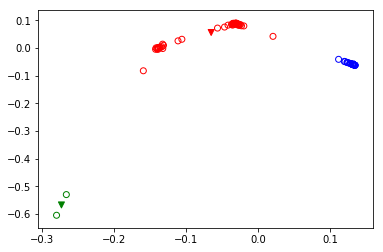

In [11]:
n = len(embedding)
colors = {0:'red',1:'blue',2:'green', 3:'orange'}

for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[clusters[i]])
    
plt.scatter(centers[:,0], centers[:,1], marker='v', color=list(colors.values()))

## Vote selection

['s84-115-27-1' 'hconres71-115-231-1' 'hr1628-115-172-1']


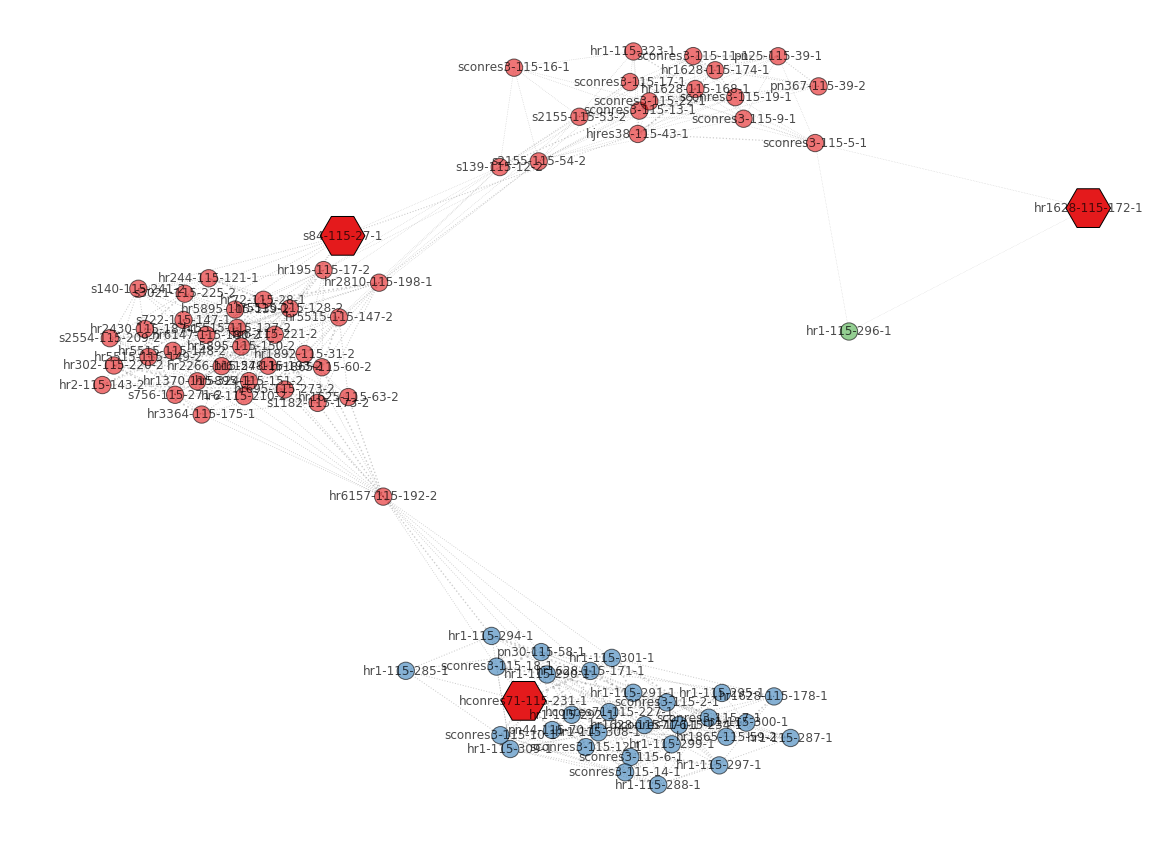

In [13]:
vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))

## Embedding you in the graph

In [14]:
your_votes = [1,1,-1]
other_senators_vote = votes_train.values[:,vote_selection]

In [15]:
def compute_similarity(senator_votes):
    return euclidean_distance(senator_votes, your_votes)

similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote)
similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)

top_similar = similarity_vector.argsort()[-3:][::-1]
similar_senators = senators.iloc[top_similar]

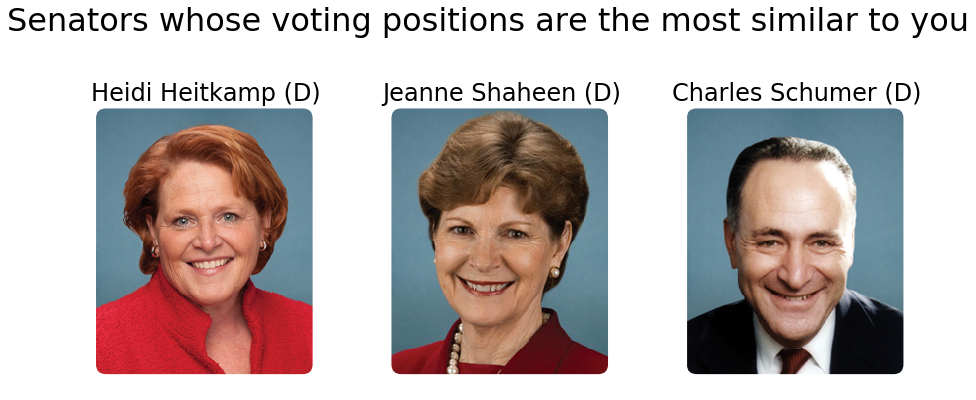

In [16]:
show_portraits(similar_senators)

In [17]:
new_columns = np.append(similarity_vector, 0)

n = len(adjacency)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns

G_new = graphs.Graph(new_adjacency)
G_new.set_coordinates('spring', seed=2018)
G_new.compute_fourier_basis()
G_new.compute_laplacian()
G_new.compute_differential_operator()

new_labels = np.append(senators['name'].values, ['you'])

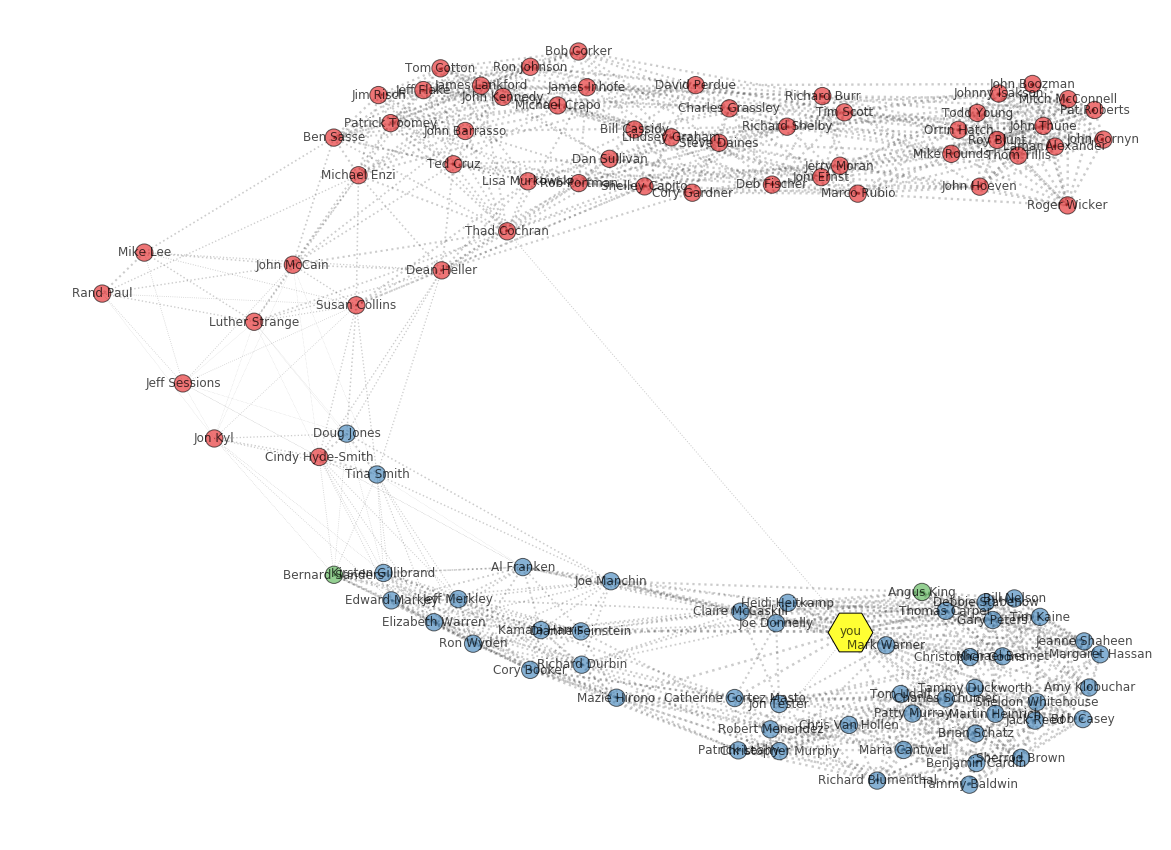

In [18]:
plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])

## Spectral analysis of the new adjacency matrix

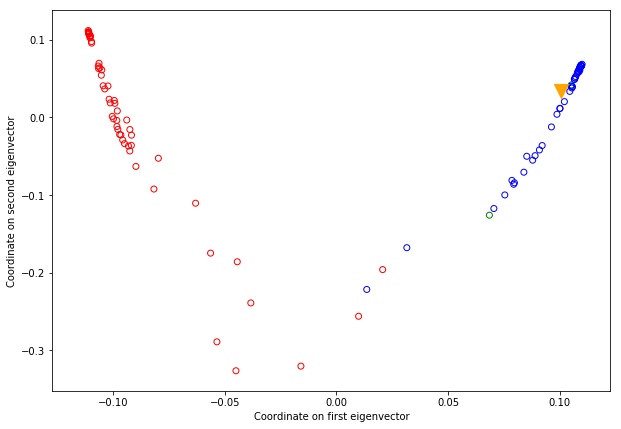

In [19]:
show_2D_embedding(G_new.U[:,1:3], senators_party)

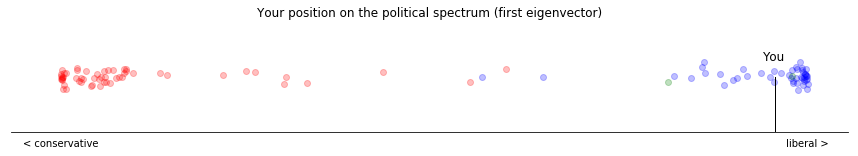

In [20]:
show_political_spectrum(G_new.U[:,1:3], n, colors, senators_party)

# Predicting votes based on votes from similar senators

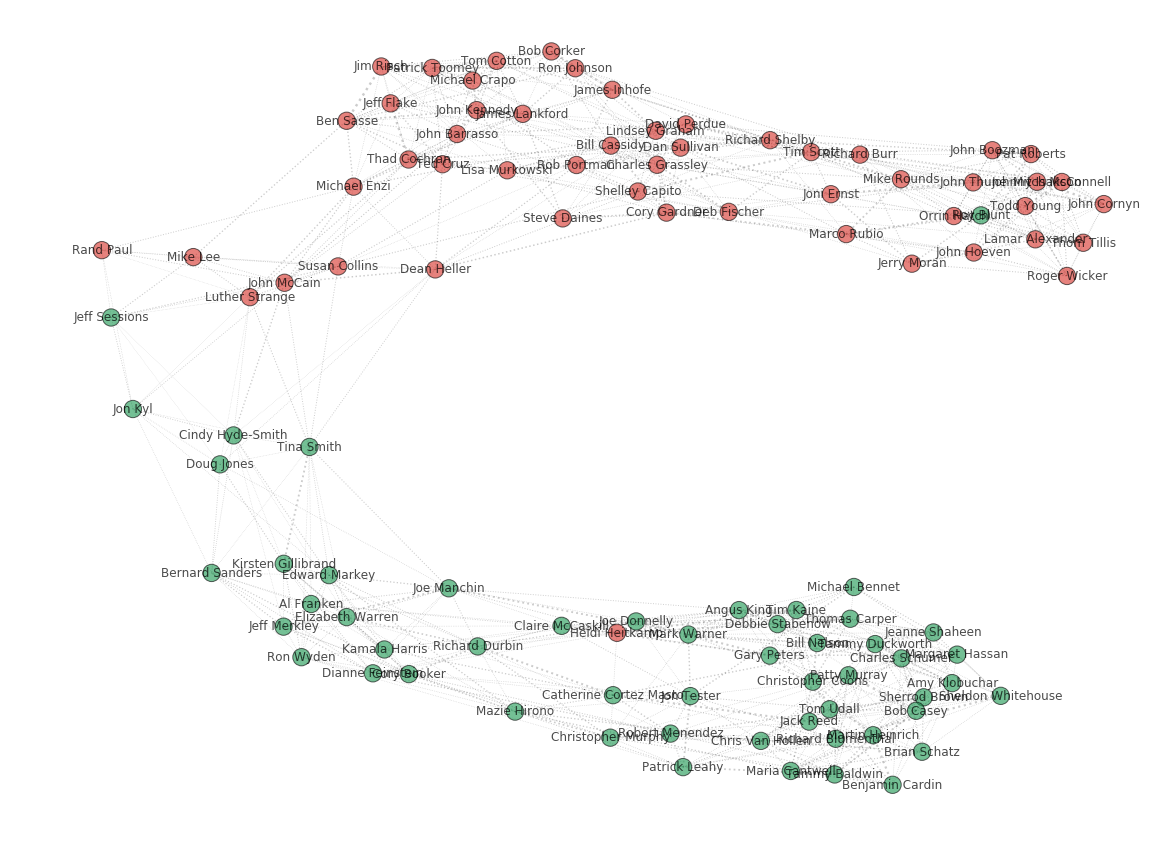

In [21]:
# Binarize labels
labels_bin = get_thresholded_values(votes_test.values[:,0], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

Error binarized: 0.2760262237369417
Accuracy binarized: 0.9809523809523809
Error non binarized: 0.5574784379294935


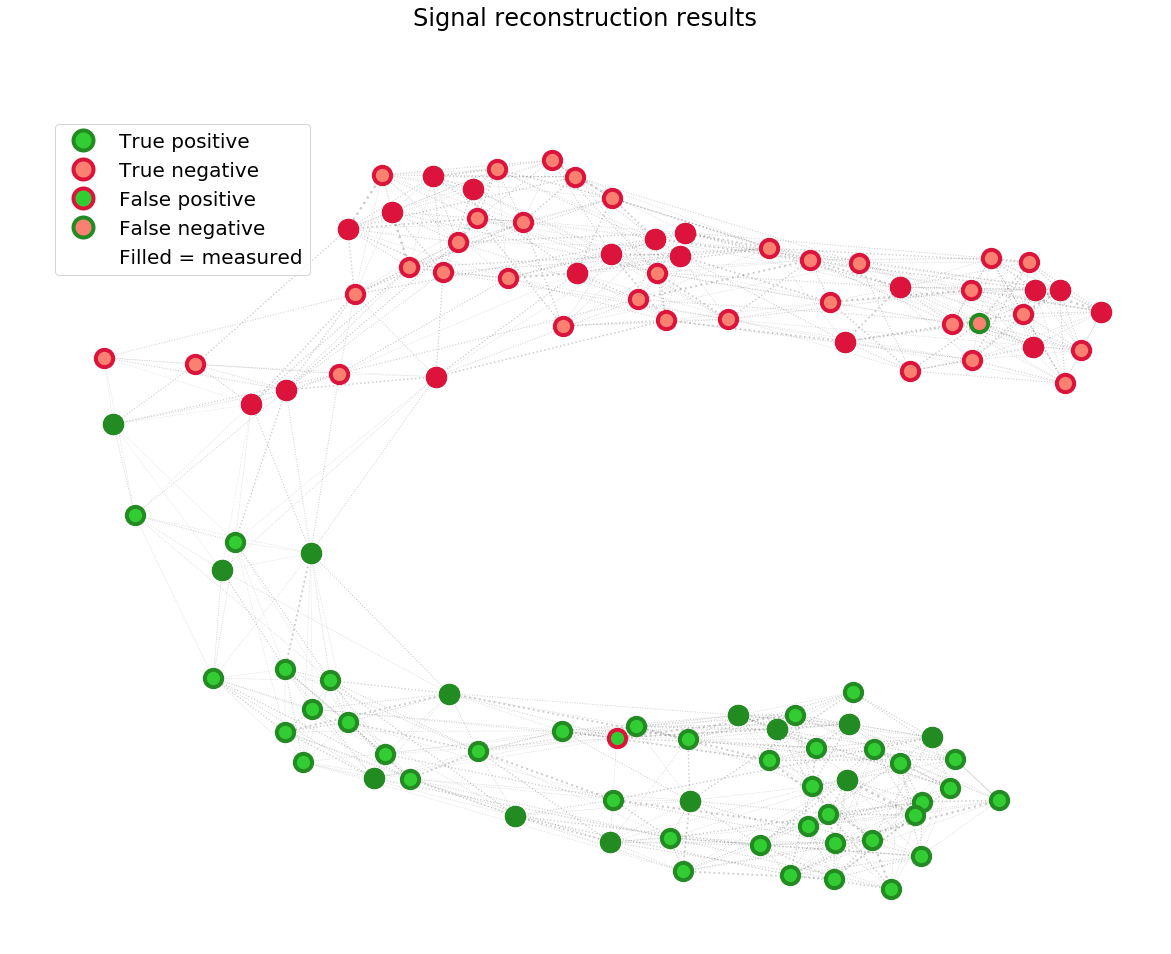

In [22]:
sol, sol_bin =  reconstruct_signal(G,w,labels_bin)
plot_prediction(G, sol_bin, labels_bin, w)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))

# What about you ?


In [23]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    w = np.append(np.ones(len(positions)), 0)    

    return reconstruct_signal(G, w, get_thresholded_values(bill_votes,0))

sol, sol_binarized = predict_your_votes(G_new, votes_train.iloc[:,2])
print("On vote x you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")

On vote x you would have voted 1.0 (1.725318654565079)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters

In [25]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

print(senators['name'].iloc[swing_senators])

predict_and_compare(G, votes_test, swing_senators)

member_id
C001035       Susan Collins
H001041         Dean Heller
H001079    Cindy Hyde-Smith
J000300          Doug Jones
K000352             Jon Kyl
M000133       Edward Markey
S000033     Bernard Sanders
S001202      Luther Strange
S001203          Tina Smith
Name: name, dtype: object
Outcome accuracy: 0.8571428571428571


([0.9523809523809523,
  0.8476190476190476,
  0.8285714285714286,
  0.5333333333333333,
  0.9523809523809523,
  0.9904761904761905,
  0.8095238095238095,
  0.5428571428571428,
  0.9619047619047619,
  0.9047619047619048,
  0.9333333333333333,
  0.5333333333333333,
  0.9523809523809523,
  0.8857142857142857,
  0.9809523809523809,
  0.9333333333333333,
  0.7714285714285715,
  0.9809523809523809,
  0.9619047619047619,
  0.5428571428571428,
  0.7238095238095238],
 [False,
  True,
  True,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True])

~85% accuracy. How does that compare to the same number of senators but picked at random ? 

In [26]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
predict_and_compare(G, votes_test, random_senators)

                      name party
member_id                       
R000605        Mike Rounds     R
F000457         Al Franken     D
M001183        Joe Manchin     D
P000603          Rand Paul     R
C001098           Ted Cruz     R
C001070          Bob Casey     D
F000444         Jeff Flake     R
C000141    Benjamin Cardin     D
H001061        John Hoeven     R
Outcome accuracy: 0.5238095238095238


([0.9619047619047619,
  0.7523809523809524,
  0.8761904761904762,
  0.9523809523809523,
  0.9619047619047619,
  0.9714285714285714,
  0.8666666666666667,
  0.9523809523809523,
  0.9714285714285714,
  0.9238095238095239,
  0.9047619047619048,
  0.9523809523809523,
  0.9619047619047619,
  0.9714285714285714,
  0.9809523809523809,
  0.9619047619047619,
  0.8095238095238095,
  0.9809523809523809,
  0.8952380952380953,
  0.9333333333333333,
  0.9619047619047619],
 [False,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  False,
  False])

In [ ]:
"""labels_bin = get_thresholded_values(votes_test.values[:,1], threshold=0)

mask = np.zeros(votes_test.shape[0])
mask[random_senators] = 1

sol, sol_bin =  reconstruct_signal(G,mask,labels_bin)
plot_prediction(G, sol_bin, labels_bin, mask)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))
